## Read raw datasets 

In [1]:
import pandas

In [2]:
meta = pandas.read_csv('./title.basics.tsv.gz', sep='\t', low_memory=False)

In [3]:
meta.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
eps = pandas.read_csv(
    './title.episode.tsv.gz', 
    sep='\t', 
    dtype=dict(seasonNumber='Int64', episodeNumber='Int64'), 
    na_values=r'\N',
)

In [5]:
eps.head()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0020666,tt15180956,1,2
1,tt0020829,tt15180956,1,1
2,tt0021166,tt15180956,1,3
3,tt0021612,tt15180956,2,2
4,tt0021655,tt15180956,2,5


In [6]:
ratings = pandas.read_csv('./title.ratings.tsv.gz', sep='\t')

In [7]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1895
1,tt0000002,5.9,253
2,tt0000003,6.5,1691
3,tt0000004,5.7,166
4,tt0000005,6.2,2506


## Create a new dataset

In [8]:
df1 = pandas.DataFrame()

In [9]:
df1['uid'] = meta.tconst
df1['title'] = meta.primaryTitle
df1.set_index('uid', inplace=True)

## Get first episode info

In [10]:
first_eps = eps[(eps.seasonNumber == 1) & (eps.episodeNumber == 1)]
first_eps.head()

,tconst,parentTconst,seasonNumber,episodeNumber
1,tt0020829,tt15180956,1,1
148,tt0050641,tt4280482,1,1
163,tt0052240,tt0793361,1,1
175,tt0052952,tt4280486,1,1
180,tt0053343,tt1845727,1,1


In [11]:
df2 = df1.join(first_eps.set_index('parentTconst'), how='inner')

In [12]:
del df2['seasonNumber']
del df2['episodeNumber']
df2.rename(columns={'tconst': 'first_uid'}, inplace=True)
df2.head()

,title,first_uid
tt0025509,Les Misérables,tt15088914
tt0038276,You Are an Artist,tt13642462
tt0039120,Americana,tt12505654
tt0039122,The Borden Show,tt2086703
tt0039123,Kraft Theatre,tt0622281


In [13]:
df3 = df2.join(ratings.set_index('tconst'), on='first_uid', how='inner')

In [14]:
df3.rename(columns={'averageRating': 'first_rating', 'numVotes': 'first_votes'}, inplace=True)
df3.head()

,title,first_uid,first_rating,first_votes
tt0040051,Studio One,tt0712569,6.0,13
tt0041024,The Ford Television Theatre,tt0581222,7.6,11
tt0041027,The Goldbergs,tt0835157,6.6,11
tt0041030,Hopalong Cassidy,tt1269893,7.7,37
tt0041036,The Life of Riley,tt0771467,6.9,14


In [15]:
df3.sort_values('first_votes', ascending=False)

,title,first_uid,first_rating,first_votes
tt2085059,Black Mirror,tt2089051,7.7,53564
tt7366338,Chernobyl,tt8162428,9.4,51882
tt0944947,Game of Thrones,tt1480055,9.0,46927
tt0903747,Breaking Bad,tt0959621,9.0,33343
tt1475582,Sherlock,tt1665071,8.9,31160
...,...,...,...,...
tt5015928,Stone House Revival,tt5197864,9.0,5
tt5021776,Pintaa syvemmältä,tt5025340,6.6,5
tt1990582,Dom 2,tt4440104,5.6,5
tt1482812,We Are Klang,tt1486160,8.8,5


## Get last episode info

In [16]:
last_seasons = eps.groupby('parentTconst').max()
last_seasons = last_seasons.loc[eps.parentTconst].seasonNumber.to_numpy()
last_seasons = pandas.Series(last_seasons).astype('Int64')

In [17]:
last_eps = eps[eps.seasonNumber == last_seasons].groupby('parentTconst').max()
last_eps.head()

,tconst,seasonNumber,episodeNumber
parentTconst,,,
tt0025509,tt15088922,1,3
tt0038276,tt13642462,1,1
tt0039120,tt12505654,1,1
tt0039122,tt4774312,1,9
tt0039123,tt1118908,11,51


In [18]:
df4 = df3.join(last_eps, how='inner')
df4.rename(columns={'tconst': 'last_uid', 'seasonNumber': 'last_season', 'episodeNumber': 'last_episode'}, inplace=True)
df4.head()

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode
tt0040051,Studio One,tt0712569,6.0,13,tt1777352,10,48
tt0041024,The Ford Television Theatre,tt0581222,7.6,11,tt0581345,5,39
tt0041027,The Goldbergs,tt0835157,6.6,11,tt2162375,5,4
tt0041030,Hopalong Cassidy,tt1269893,7.7,37,tt0604796,2,26
tt0041036,The Life of Riley,tt0771467,6.9,14,tt1427585,1,26


In [19]:
df5 = df4.join(ratings.set_index('tconst'), on='last_uid', how='inner')
df5.rename(columns={'averageRating': 'last_rating', 'numVotes': 'last_votes'}, inplace=True)
df5.head()

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode,last_rating,last_votes
tt0041030,Hopalong Cassidy,tt1269893,7.7,37,tt0604796,2,26,7.8,19
tt0041036,The Life of Riley,tt0771467,6.9,14,tt1427585,1,26,6.8,9
tt0041038,The Lone Ranger,tt0635367,7.7,229,tt0635536,5,39,7.9,28
tt0042093,The Cisco Kid,tt0541794,7.2,48,tt0541940,6,26,7.0,15
tt0042110,The Gene Autry Show,tt0586039,8.5,19,tt0586093,5,13,8.2,7


In [20]:
df5.sort_values('last_votes', ascending=False)

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode,last_rating,last_votes
tt0944947,Game of Thrones,tt1480055,9.0,46927,tt6027920,8,6,4.1,244576
tt7366338,Chernobyl,tt8162428,9.4,51882,tt9166696,1,5,9.8,58982
tt0903747,Breaking Bad,tt0959621,9.0,33343,tt2301471,5,16,9.4,27789
tt1475582,Sherlock,tt1665071,8.9,31160,tt3845892,4,3,8.2,27430
tt9140560,WandaVision,tt9601584,7.3,25237,tt9601584,1,9,7.3,25237
...,...,...,...,...,...,...,...,...,...
tt6254860,We're Not Alone,tt6299740,6.2,5,tt6299762,1,5,7.6,5
tt10534392,Inazuma Eleven Ares,tt10616838,8.7,9,tt11117344,1,26,8.6,5
tt10541120,Kerstgezel.nl,tt11779740,7.5,6,tt11779844,1,4,8.0,5
tt10546636,Student Sex Workers,tt10547582,5.6,5,tt10547594,1,2,5.6,5


## Stats

In [21]:
df6 = df5[df5.first_votes > 1000]

In [22]:
df7 = df6.copy()
df7['votes_ratio'] = df7.last_votes / df7.first_votes
df7['rating_ratio'] = df7.last_rating / df7.first_rating

In [32]:
df7.sort_values('rating_ratio', ascending=False)

,title,first_uid,first_rating,first_votes,last_uid,last_season,last_episode,last_rating,last_votes,votes_ratio,rating_ratio
tt8910494,So Far,tt8910530,3.2,2686,tt12798540,4,19,7.1,14,0.005212,2.218750
tt14482414,Racket Boys,tt14773810,4.4,1839,tt14773862,1,16,8.0,145,0.078847,1.818182
tt0458290,Star Wars: The Clone Wars,tt1288767,7.3,4451,tt9313978,7,12,9.9,13536,3.041114,1.356164
tt8712204,Batwoman,tt8815944,5.0,5055,tt18246884,3,13,6.7,303,0.059941,1.340000
tt6394324,Charmed,tt8416378,5.4,1323,tt19432996,4,13,7.2,82,0.061980,1.333333
...,...,...,...,...,...,...,...,...,...,...,...
tt0369179,Two and a Half Men,tt0735172,8.2,2091,tt4450100,12,15,3.9,3028,1.448111,0.475610
tt0944947,Game of Thrones,tt1480055,9.0,46927,tt6027920,8,6,4.1,244576,5.211840,0.455556
tt7016936,Killing Eve,tt7062890,8.5,5274,tt15079460,4,8,3.3,6648,1.260523,0.388235
tt1856010,House of Cards,tt2161930,8.5,7915,tt7576210,6,8,2.6,7613,0.961845,0.305882


## Drawing the tops

In [24]:
import plotnine as gg

In [25]:
def draw_top_by_votes(df):
    df_plot = df.sort_values('votes_ratio', ascending=False)[:20]
    # https://github.com/has2k1/plotnine/issues/295
    df_plot = df_plot.assign(title=pandas.Categorical(df_plot.title, df_plot.title[::-1], ordered=True))
    return (
        gg.ggplot(df_plot, gg.aes(x='title'))
        + gg.geom_col(gg.aes(y='votes_ratio'))
        + gg.ylab('votes ratio (last_episode/first_episode)')
        + gg.coord_flip()
    )

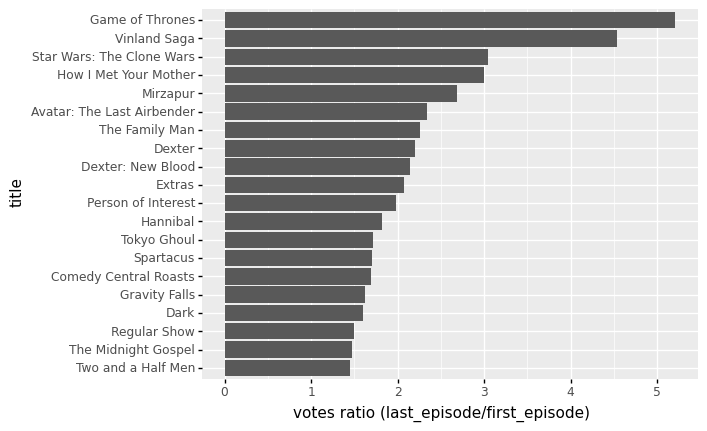

<ggplot: (8752187629623)>

In [26]:
draw_top_by_votes(df7)

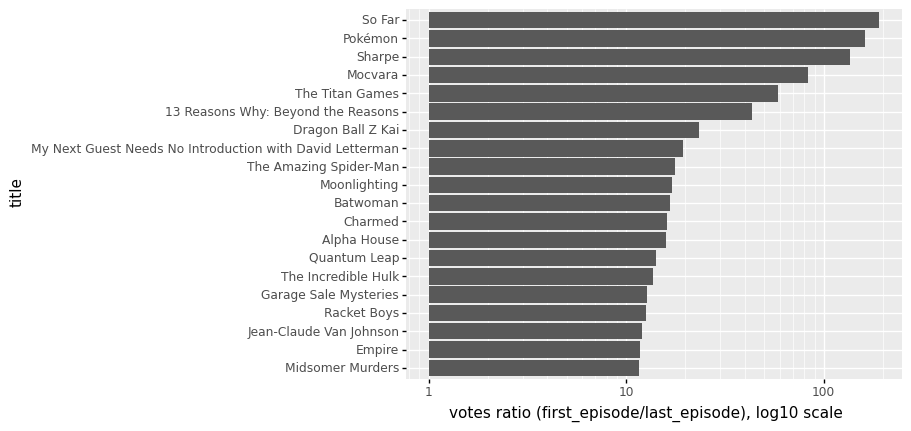

<ggplot: (8752185449469)>

In [27]:
df_plot = df7.sort_values('votes_ratio')[:20]
# https://github.com/has2k1/plotnine/issues/295
df_plot = df_plot.assign(title=pandas.Categorical(df_plot.title, df_plot.title[::-1], ordered=True))
(
    gg.ggplot(df_plot, gg.aes(x='title'))
    + gg.geom_col(gg.aes(y='1/votes_ratio'))
    + gg.ylab('votes ratio (first_episode/last_episode), log10 scale')
    + gg.scale_y_log10()
    + gg.coord_flip()
)

## Analyzing particular series

In [28]:
title = 'game of thrones'
matches = meta[(meta.originalTitle.str.lower() == title.lower()) & (meta.titleType == 'tvSeries')]
series_uid = matches.iloc[0].tconst
f'https://www.imdb.com/title/{series_uid}'

'https://www.imdb.com/title/tt0944947'

In [29]:
episodes = eps[eps.parentTconst == series_uid]
episodes = episodes.set_index('tconst').join(ratings.set_index('tconst'), how='inner')
episodes['position'] = range(len(episodes))
episodes

,parentTconst,seasonNumber,episodeNumber,averageRating,numVotes,position
tconst,,,,,,
tt1480055,tt0944947,1,1,9.0,46927,0
tt1668746,tt0944947,1,2,8.6,35597,1
tt1829962,tt0944947,1,3,8.5,33717,2
tt1829963,tt0944947,1,4,8.6,32065,3
tt1829964,tt0944947,1,5,9.0,33335,4
...,...,...,...,...,...,...
tt6027908,tt0944947,8,2,7.9,129473,68
tt6027912,tt0944947,8,3,7.5,213966,69
tt6027914,tt0944947,8,4,5.5,163570,70


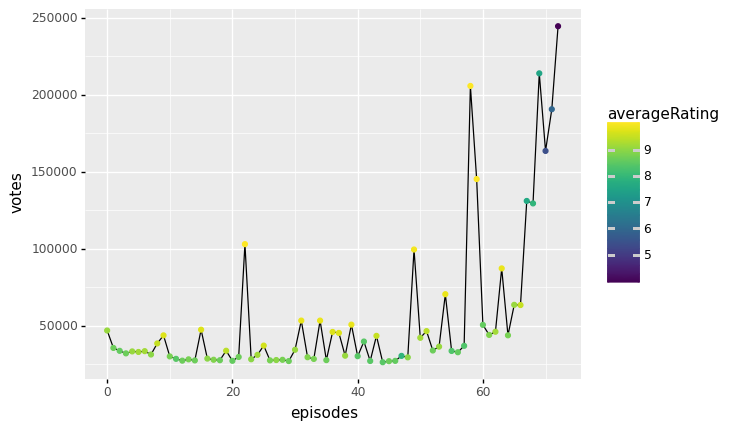

<ggplot: (8752183771853)>

In [35]:
(
    gg.ggplot(episodes.reset_index(), gg.aes(x='position', y='numVotes'))
    + gg.geom_line()
#     + gg.geom_line(gg.aes(y='averageRating * 20_000', color='1'))
    + gg.geom_point(gg.aes(color='averageRating'))
    + gg.xlab('episodes')
    + gg.ylab('votes')
)

## Drawing the filtered tops

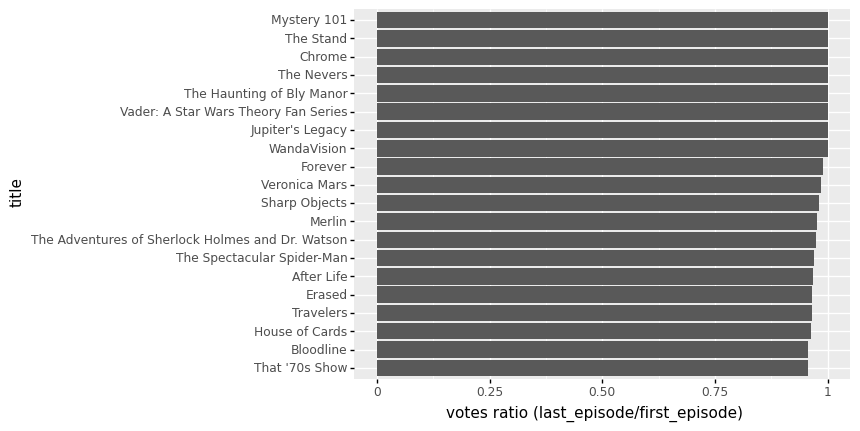

<ggplot: (8752185398152)>

In [31]:
draw_top_by_votes(df7[df7.votes_ratio <= 1.0])